# Анализ активности студентов онлайн курса

Предсказать бросит ли студент курс и почему если бросит, определить патерны поведения студентов, которые успешно проходят курс по сравнению с теми кто его бросает

## 1.1 Data preprocessing and feature engineering (Часть 1)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# размер отображаемых графиков
sns.set(rc={'figure.figsize': (9, 6)})

In [3]:
event_data = pd.read_csv('Data/event_data_train.csv')
event_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


Видим, что данные предсавлены в сыром виде (взятые из БД или логов).

В колонке `timestamp` время представлено в [Unix-формате](https://ru.wikipedia.org/wiki/Unix-%D0%B2%D1%80%D0%B5%D0%BC%D1%8F) в секундах	.

In [4]:
# проверили уникальные значения
event_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

**Работа с временем и датой** - очень важный аспект в мире *Data Science*. Практически все базы данных используют `timestamp` для определения времени события, в машинном обучении есть целое направление - анализ временных рядов, для аналитики продукта очень важно понимать, как располагаются события во времени. 

[Работа с датой](https://medium.datadriveninvestor.com/how-to-work-with-dates-in-pandas-like-a-pro-a84055a4819d)
и [ещё](https://www.geeksforgeeks.org/python-working-with-date-and-time-using-pandas/)

In [5]:
# создадим колонку даты с форматом datetime. По ней легче группироваться
event_data['date'] = pd.to_datetime(event_data['timestamp'], unit='s')
event_data.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


In [6]:
# формат данных
event_data.dtypes

step_id               int64
timestamp             int64
action               object
user_id               int64
date         datetime64[ns]
dtype: object

In [7]:
# создадим колонку с днями
event_data['day'] = event_data.date.dt.date
event_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


### Распределение активных пользователей по дням

<AxesSubplot:xlabel='day'>

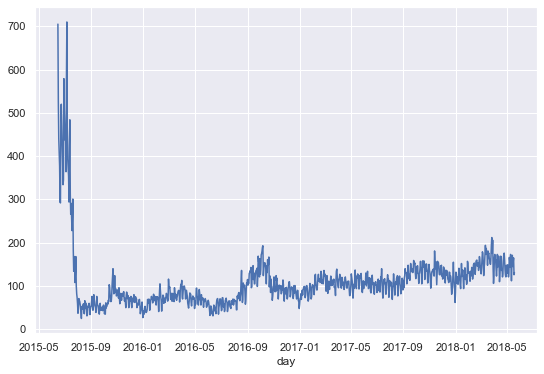

In [8]:
# количество активностей уникальных юзеров по дням 
event_data.groupby('day')['user_id'].nunique().plot()

### Распределение юзеров по пройденным степам

#### 1 ВНИМАНИЕ. Неправильный вариант!!!

<AxesSubplot:>

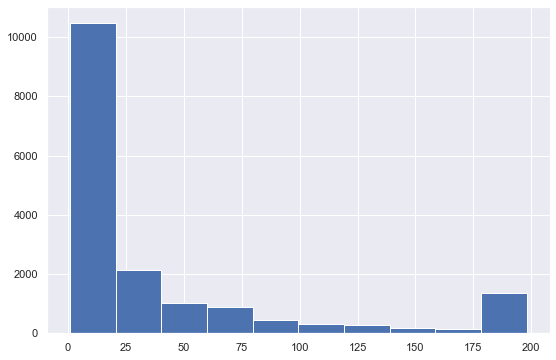

In [9]:
event_data[event_data.action == 'passed'] \
    .groupby('user_id', as_index=False) \
    .agg({'step_id': 'count'}) \
    .rename(columns={'step_id': 'passed_steps'}) \
    .passed_steps.hist()

# По горизонтали - количество пройденных степов
# По вертикали - количество юзеров

Пользователи, у которых нет ни одного `passed` стэпа вообще не попадут в результат

#### 2 Правильный вариант

In [10]:
#сводная таблица
pivot = event_data.pivot_table(index='user_id', #в результате каждая строчка будет информацией о каждом уникальном index
               columns='action', #столбцы будут отвеать за уникальные значения columns 
               values='step_id', #в ячейках будет находиться информация по values
               aggfunc='count', #сгруппированная по aggfunc
               fill_value=0)\
                .reset_index() #сбрасываем индексы
pivot.tail()

action,user_id,discovered,passed,started_attempt,viewed
19229,26790,8,8,1,9
19230,26793,1,0,1,1
19231,26794,69,69,34,180
19232,26797,10,10,2,13
19233,26798,12,12,3,12


<AxesSubplot:>

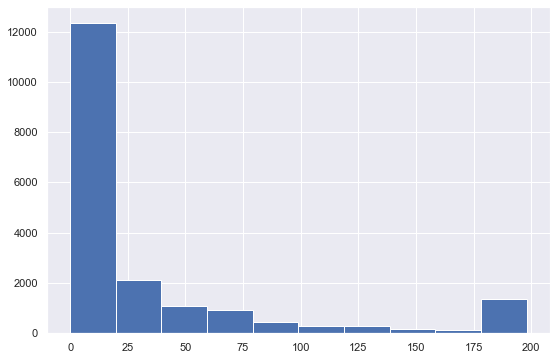

In [11]:
# По горизонтали - количество пройденных степов
# По вертикали - количество юзеров
pivot.passed.hist()

Количество юзеров в первом столбце стало больше, учли тех, кто не прошел ни одного степа

## 1.2 Data preprocessing and feature engineering (Часть 2)

Познакомимся с объединением датафреймов [merge и join](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html)

Подгрузим данные о времени и статусах сабмитов к практическим заданиям

In [12]:
submission_data = pd.read_csv('Data/submissions_data_train.csv')
submission_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


Добавим колонки с датой как делали ранее

In [13]:
submission_data['date'] = pd.to_datetime(submission_data['timestamp'], unit='s')
submission_data['day'] = submission_data.date.dt.date
submission_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


Рассчитаем для каждого юзера сколько у него было правильных и неправильных ответов

In [14]:
users_score = submission_data.pivot_table(index='user_id', #в результате каждая строчка будет информацией о каждом уникальном index
               columns='submission_status', #столбцы будут отвеать за уникальные значения columns 
               values='step_id', #в ячейках будет находиться информация по values
               aggfunc='count', #сгруппированная по aggfunc
               fill_value=0).reset_index()
users_score.tail()

submission_status,user_id,correct,wrong
9935,26787,3,0
9936,26790,1,0
9937,26794,33,9
9938,26797,2,0
9939,26798,2,1


### Ключевой момент

Для предсказания дропнится юзер с курса или дорешает его до конца необходимо понять кого считать за дропнувшегося юзера. В данных это не указано.

Надо научиться отличать юзеров:
+ незакончившие курс вообще
+ юзеры в процессе

Для этого можно посмотреть как распределяются временные промежутки между активностями юзеров по дням и статистически решить кого считать за дропнувшегося юзера

### Расчет временного промежутка в днях между действиями пользователя на степике

In [15]:
# удалили дубликаты в данных, чтобы остались уникальные действия юзеров по дням
event_data.drop_duplicates(subset=['user_id', 'day'])[['user_id', 'day', 'timestamp']] \
.groupby('user_id')['timestamp'].apply(list).head()

user_id
1                                         [1472827464]
2                             [1514383364, 1519226966]
3    [1434358476, 1441257725, 1441440209, 144153391...
5                             [1466156809, 1499859621]
7                                         [1521634660]
Name: timestamp, dtype: object

`np.diff` считает разность между ближайшими наблюдениями

In [16]:
# сгруппировали по юзерам и создали эрэй промежутков между днями
gap_data = event_data.drop_duplicates(subset=['user_id', 'day'])[['user_id', 'day', 'timestamp']] \
.groupby('user_id')['timestamp'].apply(list).apply(np.diff).values
gap_data

array([array([], dtype=int32), array([4843602]),
       array([6899249,  182484,   93710, 2768870,  171400,   78712]), ...,
       array([   86128,   136759,    94899,  1422583, 14347289,   505061,
                 98252,    57019])                                       ,
       array([1567990]), array([], dtype=int32)], dtype=object)

In [17]:
# Создали серию из объединенного эрея
gap_data = pd.Series(np.concatenate(gap_data, axis=0))

In [18]:
# в днях промежутки
gap_data = gap_data / (24*60*60) 
gap_data[:10]

0     56.060208
1     79.852419
2      2.112083
3      1.084606
4     32.047106
5      1.983796
6      0.911019
7    390.078843
8      9.994028
9      0.589468
dtype: float64

<AxesSubplot:>

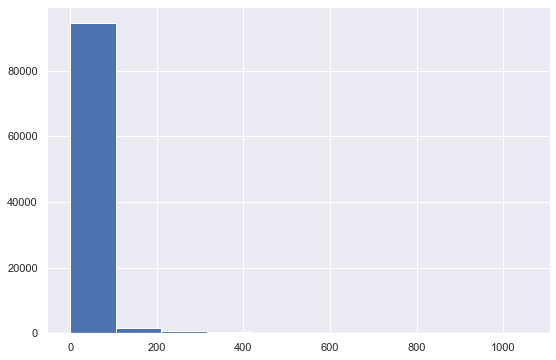

In [19]:
gap_data.hist()

<AxesSubplot:>

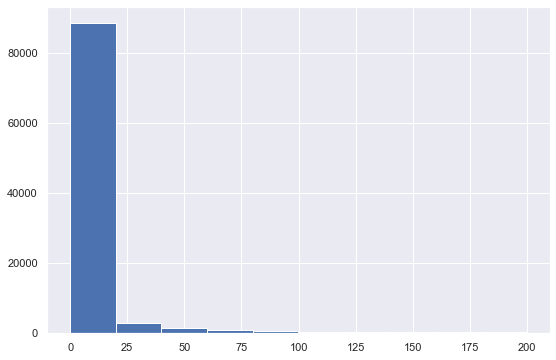

In [20]:
# для отсечения выбросов возьмем порог 200 дней
gap_data[gap_data < 200].hist()

In [21]:
# 95% всех юзеров совершали действия в пределах ~60 дней
gap_data.quantile(.95)

59.760440972222156

In [22]:
# 90% всех юзеров совершали действия в пределах ~18 дней
gap_data.quantile(.90)

18.325995370370403

Мы можем взять значение 30 дней в качестве оценки между 90-м и 95-м процентилем.

### *Промежуочное задание. ID Анатолия Карпова

Создатель курса по идеи должен совершить большее количество попыток решения степа для проверки работает он или нет

In [23]:
submission_data[submission_data.submission_status == 'correct'].groupby('user_id') \
.agg({'submission_status':'count'}).sort_values(by=['submission_status'], ascending=False).head(3)

,submission_status
user_id,
1046,421
5552,186
17135,168


In [24]:
submission_data.pivot_table(index='user_id', columns='submission_status' \
                           , values='step_id', aggfunc='count', fill_value=0) \
.reset_index().sort_values(['correct', 'wrong'], ascending=False).head(3)

submission_status,user_id,correct,wrong
439,1046,421,513
2099,5552,186,93
6415,17135,168,177


### Люди не заходившие больше месяца

Если человек не получил сертификат и при этому более 30 дней отсутствует на платформе - считаем, что он дропнулся с курса.

In [25]:
users_data = event_data.groupby('user_id', as_index = False).agg({'timestamp': 'max'})\
            .rename(columns={'timestamp': 'last_timestamp'})
users_data.head()

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660


In [26]:
#максимальный таймстемп будем считать за время выгрузки данных
now = event_data['timestamp'].max()
now

1526772811

In [27]:
# 30 дней в секундах
one_month_in_second = 30*24*60*60
one_month_in_second

2592000

In [28]:
#создали колонку показывающая - ушел юзер или нет
users_data['is_gone_user'] = (now - users_data['last_timestamp']) > one_month_in_second
users_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


Сведем полученные результаты в одну таблицу для этого применим `merge`

In [29]:
users_data = users_data.merge(users_score, how='outer', on='user_id').fillna(0)
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0


In [30]:
users_data = users_data.merge(pivot, how='outer', on='user_id')
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1


Cколько уникальных дней пользователь был в сервисе

In [33]:
users_days = event_data.groupby('user_id')[['day']].nunique()
users_days.head()

,day
user_id,
1,1
2,2
3,7
5,2
7,1


In [34]:
users_data = users_data.merge(users_days, how='outer', on='user_id')
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


Проверяем, что мы никого не потеряли, смотрим на количество юзеров.

In [35]:
users_data.user_id.nunique()

19234

In [36]:
event_data.user_id.nunique()

19234

### Юзеры прошедшие курс

Последняя колонка которую мы хоти добавить - показатель того, что пользователь успешно закончил курс.

Например, пользователь набрал более 170 пройденных шагов.

In [37]:
users_data['passed_course'] = users_data.passed > 170
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [38]:
users_data.groupby('passed_course').count()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
passed_course,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


In [39]:
# 7% прошли курс
1425 / (17809 + 1425) * 100

7.408755329104711

У нас были сырые логи, а теперь есть данные с фичами по каждому юзеру.

Наш датафрейм бесполезный с точки зрения машинного обучения, так как мы знаем за весь период данные о юзерах.

Было бы интересней основываясь на данных, например недели, предсказать юзер пройдет курс или нет.

## 2.1 Machine learning. Начало (НЕТ)

Предскажем дропнется юзер или нет по поведению юзера по первым 3 дням

Для этого продолжим предподгатавливать данные. Оставим только события первых 3 дней каждого юзера

In [40]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [41]:
event_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [42]:
#определим первое действие юзера
user_min_time = event_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'min'}) \
    .rename({'timestamp': 'min_timestamp'}, axis=1)

In [43]:
user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [44]:
users_data = users_data.merge(user_min_time, how='outer')
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


Пример нежелательного способа отбора первых 3 дней, так как способ медленный

In [45]:
# создадим датафрейм для для дальнейшего машинного обучения
# event_data_train = pd.DataFrame()

In [46]:
# for user_id in users_data.user_id:
#     min_user_time = users_data[users_data.user_id == user_id].min_timestamp.item()
#     time_treshold = min_user_time + 3 * 24 * 60 * 60 # minimal timestamp + 3 days in seconds
#     user_events_data = event_data[(event_data.user_id == user_id) & (event_data.timestamp < time_treshold)]
#     event_data_train.append(user_events_data)
    

Альтернативный подход

In [47]:
# создадим колонку с id и timestamp
event_data['user_time'] = event_data.user_id.map(str) + '_' + event_data.timestamp.map(str)

In [48]:
# порог в 3 дня в секундах
learning_time_treshold = 3 * 24 * 60 * 60
learning_time_treshold

259200

In [49]:
user_learning_time_treshold = user_min_time.user_id.map(str) + '_'\
+ (user_min_time.min_timestamp + learning_time_treshold).map(str)

In [50]:
user_min_time['user_learning_time_treshold'] = user_learning_time_treshold

In [51]:
event_data = event_data.merge(user_min_time[['user_id', 'user_learning_time_treshold']], how='outer')

In [52]:
event_data.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_treshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


In [53]:
# отберем данные первых 3 дней
events_data_train = event_data[event_data.user_time <= event_data.user_learning_time_treshold]

In [54]:
events_data_train.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_treshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


### *Промежуточная задача. Определить степ йд на котором больше всего людей не проходят и уходят

In [55]:
submission_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [56]:
step_score = submission_data.pivot_table(index='step_id', #в результате каждая строчка будет информацией о каждом уникальном index
               columns='submission_status', #столбцы будут отвеать за уникальные значения columns 
               values='user_id', #в ячейках будет находиться информация по values
               aggfunc='count', #сгруппированная по aggfunc
               fill_value=0).reset_index()
users_score.tail()

submission_status,user_id,correct,wrong
9935,26787,3,0
9936,26790,1,0
9937,26794,33,9
9938,26797,2,0
9939,26798,2,1


In [57]:
step_score.sort_values(by='wrong', ascending=False).iloc[0, 0]

31978

## Продолжаем работать с events_data_train

In [58]:
events_data_train.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_treshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


Давайте проверим максимальное число дней:

In [59]:
events_data_train.groupby('user_id').day.nunique().max()

4

Такое может быть, например, когда пользователь начал 1-го числа в середине дня, и трое суток в этом случае заденут и четвёртое число тоже. Но число больше 4-х мы уже никак не можем ожидать в наших данных, потому что это заложено в наш с вами порог.

Чтобы сэкономить наше время тоже самое проделаем с данными submissons_data

In [60]:
submission_data['user_time'] = submission_data.user_id.map(str) + '_' + submission_data.timestamp.map(str)
submission_data = submission_data.merge(user_min_time[['user_id', 'user_learning_time_treshold']], how='outer')
submission_data_train = submission_data[submission_data.user_time <= submission_data.user_learning_time_treshold]
submission_data_train.groupby('user_id').day.nunique().max()

4

Заведём датафрейм `X`, который постепенно будем наполнять данными.

In [151]:
X = submission_data_train.groupby('user_id').day.nunique(). \
    to_frame().reset_index().rename(columns=({
        'day': 'days'
}))

In [152]:
X.head()

,user_id,days
0,2,1
1,3,1
2,8,1
3,14,1
4,16,3


Получим для каждого пользователя число уникальных степов, которые он попытался решить.

In [153]:
steps_tried = submission_data_train.groupby('user_id').step_id \
    .nunique().to_frame().reset_index().rename(columns={
        'step_id': 'steps_tried'
})

In [154]:
steps_tried.head()

,user_id,steps_tried
0,2,2
1,3,4
2,8,11
3,14,1
4,16,23


In [155]:
X = X.merge(steps_tried, on='user_id', how='outer')
X.head()

,user_id,days,steps_tried
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,3,23


Добавим число правильных и неправильных попыток и отношение правильности к неправильности.

In [156]:
X = X.merge(submission_data_train.pivot_table(index='user_id',
                        columns='submission_status',
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index())

In [157]:
X.head()

,user_id,days,steps_tried,correct,wrong
0,2,1,2,2,0
1,3,1,4,4,4
2,8,1,11,9,21
3,14,1,1,0,1
4,16,3,23,23,27


Можно сильно помочь нашим данным, упростив им задачу. Сделаем долю правильных ответов от общей суммы ответов.

In [158]:
X['correct_ratio'] = X.correct / (X.correct + X.wrong)

In [159]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.00
1,3,1,4,4,4,0.50
2,8,1,11,9,21,0.30
3,14,1,1,0,1,0.00
4,16,3,23,23,27,0.46


In [160]:
X = X.merge(events_data_train.pivot_table(index='user_id',
                        columns='action',
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()[['user_id', 'viewed']], how='outer')

Мы можем убедиться в том, что у нас появились некоторые пропуски в данных после этого джойна. Заполним их пока нулём.

In [161]:
X = X.fillna(0)

Временно расширим датафрейм X для правильной разметки выборки.

Нам нужно взять данные из `user_data` про то:

+ закончил ли человек курс успешно
+ правда ли, что он уже не пытается это сделать

In [162]:
X = X.merge(users_data[['user_id', 'passed_course', 'is_gone_user']], how='outer')

In [163]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True


In [164]:
X[(X.is_gone_user == False) & (X.passed_course == False)].head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
7,25,1.0,2.0,1.0,4.0,0.200000,40,False,False
11,32,1.0,3.0,3.0,0.0,1.000000,14,False,False
20,57,3.0,13.0,13.0,28.0,0.317073,70,False,False
30,78,1.0,2.0,2.0,0.0,1.000000,13,False,False
53,156,1.0,2.0,2.0,0.0,1.000000,10,False,False


Это все пользователи, не дошедшие до конца курса и не бросившие его ещё. А нам нужно обратное. То есть нам нужны все, кроме этих комбинаций.

Тогда обернём инструкцию выше в скобки и используем знак отрицания: ~

In [165]:
X[~((X.is_gone_user == False) & (X.passed_course == False))].head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True


In [166]:
X = X[~((X.is_gone_user == False) & (X.passed_course == False))]

In [167]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True


Теперь в `X` находятся пользователи, которые либо прошли курс, либо бросили его.

Целевой переменной `y` здесь является `passed_course`.

In [168]:
y = X.passed_course.map(int)

In [169]:
X = X.drop(['passed_course', 'is_gone_user'], axis=1)

Обратите внимание, что в `X` у нас хранится `user_id` и кажется, что странно использовать эту колонку для обучения нашей модели, потому что она навряд ли несёт какую-то логику.

In [170]:
X = X.set_index(X.user_id)
X = X.drop('user_id', axis=1)

In [172]:
X.head()

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9
3,1.0,4.0,4.0,4.0,0.50,20
8,1.0,11.0,9.0,21.0,0.30,154
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,132


`X` теперь стал более похож на обучающую выборку с которой можно провести эксперименты - логистическая регрессия, дерево решений, оценка метрик, замена параметров и т.д.

Проделав всё это, можно будет ответить на вопрос - сможем ли мы предсказать отток студентов за первые несколько дней.

## 2.2 Machine learning

Обучим несколько моделей и сравним их

In [82]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

### 2.2.1 Модель - дерево решений

In [83]:
from sklearn.tree import DecisionTreeClassifier

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [85]:
clf_dt = DecisionTreeClassifier(random_state = 42)

In [86]:
parameters = {'criterion': ['gini', 'entropy'],
              'max_depth': range(1, 13, 2),
              'min_samples_leaf': range(1, 8),
              'min_samples_split': range(2, 10, 2)}

In [87]:
grid_search_clf_dt = GridSearchCV(clf_dt, parameters, cv=5)

In [88]:
grid_search_clf_dt.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 13, 2),
                         'min_samples_leaf': range(1, 8),
                         'min_samples_split': range(2, 10, 2)})

In [89]:
grid_search_clf_dt.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

In [90]:
y_pred = grid_search_clf_dt.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [372]:
dt_score_cv = cross_val_score(grid_search_clf_dt.best_estimator_, X_train, y_train, cv=4).mean()
dt_score_cv

0.916756940596944

In [92]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
roc_auc

0.5703040257715389

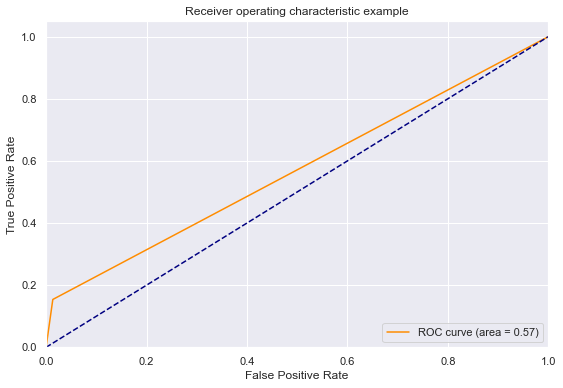

In [93]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### 2.2.2 Модель - логистическая регрессия

In [94]:
from sklearn.linear_model import LogisticRegression

In [95]:
clf_lg = LogisticRegression(random_state=42)

In [96]:
parameters = {'penalty':['l2'],
             'tol': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
             'C': [1.0, 2.0, 3.0, 4.0, 5.0]}

In [97]:
grid_search_clf_lg = GridSearchCV(clf_lg, parameters, cv=5)

In [98]:
grid_search_clf_lg.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [1.0, 2.0, 3.0, 4.0, 5.0], 'penalty': ['l2'],
                         'tol': [0.01, 0.001, 0.0001, 1e-05, 1e-06]})

In [99]:
grid_search_clf_lg.best_params_

{'C': 1.0, 'penalty': 'l2', 'tol': 0.01}

In [100]:
y_pred = grid_search_clf_lg.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [371]:
lg_score_cv = cross_val_score(grid_search_clf_lg.best_estimator_, X_train, y_train, cv=4).mean()
lg_score_cv

0.9190807573996523

In [102]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
roc_auc

0.575309380516978

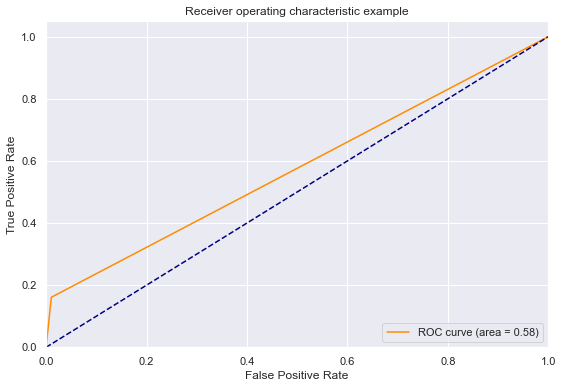

In [103]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Еще одня регрессия

In [104]:
from sklearn.linear_model import LogisticRegressionCV

In [105]:
clf_lgcv = LogisticRegressionCV(cv=5, random_state=42)

In [106]:
clf_lgcv.fit(X_train, y_train)

LogisticRegressionCV(cv=5, random_state=42)

In [107]:
y_pred = clf_lgcv.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [108]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
roc_auc

0.5740338681202695

In [370]:
lgcv_score_cv = cross_val_score(clf_lgcv, X_train, y_train, cv=4).mean()
lgcv_score_cv

0.9184169396096331

### 2.2.3 Модель - К-ближайших соседей

In [112]:
from sklearn.neighbors import KNeighborsClassifier

In [113]:
clf_knn = KNeighborsClassifier()

In [114]:
parameters = {'n_neighbors': range(1, 10),
             'leaf_size': range(5, 60, 5)
             }

In [115]:
grid_search_knn = GridSearchCV(clf_knn, parameters, cv=5)

In [116]:
grid_search_knn.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': range(5, 60, 5),
                         'n_neighbors': range(1, 10)})

In [117]:
grid_search_knn.best_params_

{'leaf_size': 40, 'n_neighbors': 8}

In [118]:
y_pred = grid_search_knn.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [119]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
roc_auc

0.5557172866310142

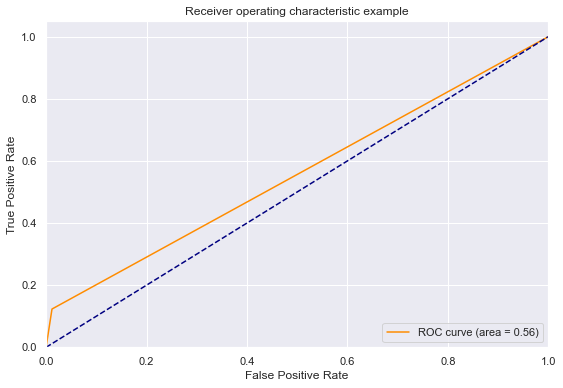

In [120]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [369]:
knn_score_cv = cross_val_score(grid_search_knn.best_estimator_, X_train, y_train, cv=4).mean()
knn_score_cv

0.9153459731160544

In [390]:
print(f'KNeighborsClassifier: {knn_score_cv:^14.4f}')
print(f'DecisionTreeClassifier: {dt_score_cv:^10.4f}')
print(f'LogisticRegressionCV: {lgcv_score_cv:^15.4f}')
print(f'LogisticRegression: {lg_score_cv:^19.4f}')

KNeighborsClassifier:     0.9153    
DecisionTreeClassifier:   0.9168  
LogisticRegressionCV:     0.9184     
LogisticRegression:       0.9191       


# 3 Финальное задание

В данных:
+ submission_data_test.csv
+ events_data_test.csv

хранится информация о решениях и действиях для 6184 студентов за первые два дня прохождения курса. 

Используя данные о первых двух днях активности на курсе вам нужно предсказать, наберет ли пользователь более 40 баллов на курсе или нет.

## 3.1 Загрузка тестовых данных

In [310]:
sub_test = pd.read_csv('https://stepik.org/media/attachments/course/4852/submission_data_test.csv')
sub_test.head()

,step_id,timestamp,submission_status,user_id
0,31971,1526800961,wrong,24370
1,31971,1526800976,wrong,24370
2,31971,1526800993,wrong,24370
3,31971,1526801054,correct,24370
4,31972,1526800664,wrong,24370


In [311]:
events_test = pd.read_csv('https://stepik.org/media/attachments/course/4852/events_data_test.csv')
events_test.head()

,step_id,timestamp,action,user_id
0,30456,1526893787,viewed,24417
1,30456,1526893797,viewed,24417
2,30456,1526893954,viewed,24417
3,30456,1526895780,viewed,24417
4,30456,1526893787,discovered,24417


In [312]:
answer_data = pd.read_csv('Data/submission_example.csv')
answer_data.head()

,user_id,is_gone
0,12,0.26
1,13,0.79
2,15,0.12
3,21,0.67
4,35,0.62


Сформируем `X_test` из тестовых данных по аналогии как мы делали с `X` на предыдущих шагах. А также подправим `X` (он же `X_train`) в соответсвие с требуемыми условиями

## 3.2 Формирование X_test на котором будем предсказывать результат

In [313]:
# добавление колонок даты и дней
events_test['date'] = pd.to_datetime(events_test['timestamp'], unit='s')
events_test['day'] = events_test.date.dt.date

sub_test['date'] = pd.to_datetime(sub_test['timestamp'], unit='s')
sub_test['day'] = sub_test.date.dt.date

In [343]:
# формирование X_test
X_test = sub_test.groupby('user_id').day.nunique(). \
    to_frame().reset_index().rename(columns=({
        'day': 'days'
}))

steps_tried = sub_test.groupby('user_id').step_id \
    .nunique().to_frame().reset_index().rename(columns={
        'step_id': 'steps_tried'
})

X_test = X_test.merge(steps_tried, on='user_id', how='outer')

X_test = X_test.merge(sub_test.pivot_table(index='user_id',
                        columns='submission_status',
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index())

X_test['correct_ratio'] = X_test.correct / (X_test.correct + X_test.wrong)

X_test = X_test.merge(events_test.pivot_table(index='user_id',
                        columns='action',
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()[['user_id', 'viewed']], how='outer')

# X_test['viewed_ratio'] = X_test.viewed / (X_test.viewed + X_test.discovered)
X_test = X_test.fillna(0)

In [344]:
X_test = X_test.set_index('user_id')
X_test.head()

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
12,1.0,1.0,1.0,0.0,1.000000,14
13,2.0,29.0,29.0,36.0,0.446154,105
15,3.0,11.0,10.0,30.0,0.250000,1
21,1.0,30.0,24.0,103.0,0.188976,98
35,3.0,9.0,7.0,35.0,0.166667,70


## 3.3 Формирование X_train и y_train на котором будем обучать модель

In [345]:
# порог прохождения курса - 40 пройденных степов
users_data['passed_course'] = users_data.passed > 40
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,True,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


Оставим данные за первые 2 дня

In [346]:
# 2 дня в секундах
time_treshold = 2 * 24 * 60 * 60

In [347]:
users_min_time = users_data[['user_id', 'min_timestamp']].copy()

In [348]:
users_min_time['time_treshold'] = users_min_time['min_timestamp'] + time_treshold

In [349]:
event_data_train = event_data.merge(users_min_time[['user_id', 'time_treshold']], how='outer')
event_data_train = event_data_train[event_data_train.timestamp <= event_data_train.time_treshold]

In [350]:
sub_data_train = submission_data.merge(users_min_time[['user_id', 'time_treshold']], how='outer')
sub_data_train = sub_data_train[sub_data_train.timestamp <= sub_data_train.time_treshold]

In [351]:
event_data_train.groupby('user_id').day.nunique().max()

3

In [352]:
sub_data_train.groupby('user_id').day.nunique().max()

3

Создание `X_train`

In [353]:
X = sub_data_train.groupby('user_id').day.nunique(). \
    to_frame().reset_index().rename(columns=({
        'day': 'days'
}))

steps_tried = sub_data_train.groupby('user_id').step_id \
    .nunique().to_frame().reset_index().rename(columns={
        'step_id': 'steps_tried'
})

X = X.merge(steps_tried, on='user_id', how='outer')

X = X.merge(sub_data_train.pivot_table(index='user_id',
                        columns='submission_status',
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index())

X['correct_ratio'] = X.correct / (X.correct + X.wrong)

X = X.merge(event_data_train.pivot_table(index='user_id',
                        columns='action',
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()[['user_id', 'viewed']], how='outer')


# X['viewed_ratio'] = X.viewed / (X.viewed + X.discovered)

X = X.merge(users_data[['user_id', 'passed_course', 'is_gone_user']], how='outer')
X = X[~((X.is_gone_user == False) & (X.passed_course == False))]

X = X.fillna(0)

In [354]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.000000,9,False,True
1,3,1.0,4.0,4.0,4.0,0.500000,20,True,True
2,8,1.0,11.0,9.0,21.0,0.300000,154,True,True
3,14,1.0,1.0,0.0,1.0,0.000000,9,False,True
4,16,2.0,18.0,18.0,23.0,0.439024,117,True,True


In [355]:
y = X.passed_course.map(int)
X = X.drop(['passed_course', 'is_gone_user'], axis=1)

In [356]:
X = X.set_index('user_id')

In [357]:
X.head()

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.000000,9
3,1.0,4.0,4.0,4.0,0.500000,20
8,1.0,11.0,9.0,21.0,0.300000,154
14,1.0,1.0,0.0,1.0,0.000000,9
16,2.0,18.0,18.0,23.0,0.439024,117


In [358]:
y.head()

0    0
1    1
2    1
3    0
4    1
Name: passed_course, dtype: int64

## 3.4 Обучение модели предсказания

In [359]:
from sklearn.ensemble import RandomForestClassifier

In [360]:
clf_rf = RandomForestClassifier(random_state=42)

In [361]:
parametrs = {'n_estimators': range(10, 51, 10),
            'max_depth': range(1, 13, 2),
            'min_samples_leaf': range(1, 8),
            'min_samples_split': range(2, 10, 2)}

In [362]:
grid_search_cv_rf = GridSearchCV(clf_rf, parametrs, cv=3, n_jobs=-1)
grid_search_cv_rf.fit(X, y)
grid_search_cv_rf.best_params_

{'max_depth': 7,
 'min_samples_leaf': 7,
 'min_samples_split': 2,
 'n_estimators': 10}

In [363]:
best_clf = grid_search_cv_rf.best_estimator_

In [391]:
rf_score_cv = cross_val_score(best_clf, X, y, cv=4).mean()
rf_score_cv

0.7625712025279221

<AxesSubplot:>

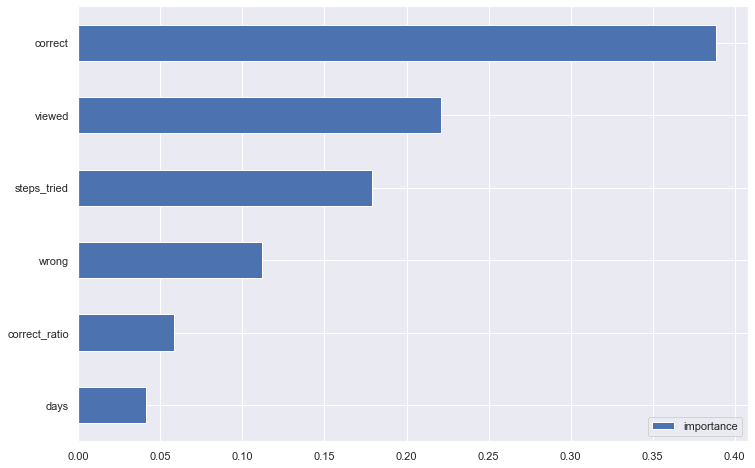

In [364]:
imp = pd.DataFrame(best_clf.feature_importances_, index=X.columns, columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(12, 8))

In [365]:
y_pred = best_clf.predict(X_test)
np.bincount(y_pred)

array([5062, 1122], dtype=int64)

In [366]:
y_pred_prob = best_clf.predict_proba(X_test)
y_pred_prob

array([[0.75699956, 0.24300044],
       [0.00421648, 0.99578352],
       [0.53531492, 0.46468508],
       ...,
       [0.96143122, 0.03856878],
       [0.96143122, 0.03856878],
       [0.96143122, 0.03856878]])

In [367]:
answer = pd.DataFrame({'user_id': X_test.index, 'is_gone':y_pred_prob[:, 1]})
answer.head()

,user_id,is_gone
0,12,0.243000
1,13,0.995784
2,15,0.464685
3,21,0.922290
4,35,0.412191


In [368]:
answer.to_csv('Data/answer.csv')